Installing necessary libraries:

In [1]:
!pip install swig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [ ]:
!pip install wrds

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import config

# Stuff from FinRL library we need:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.data_processor import DataProcessor
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent

In [5]:
import os
if not os.path.exists("./datasets"):
    os.makedirs("./datasets")
if not os.path.exists("./trained_models"):
    os.makedirs("./trained_models")
if not os.path.exists("./tensorboard_log"):
    os.makedirs("./tensorboard_log")
if not os.path.exists("./results"):
    os.makedirs("./results")

In [6]:
print("Training start date: ", config.TRAIN_START_DATE)
print("Training end date: ", config.TRAIN_END_DATE)

Training start date:  2009-01-01
Training end date:  2021-07-31


In [7]:
print("Trade start date: ", config.TRADE_START_DATE)
print("Trade end date: ", config.TRADE_END_DATE)

Trade start date:  2022-03-01
Trade end date:  2022-04-01


In [8]:
print("Training parameters: ", config.DDPG_PARAMS)

Training parameters:  {'batch_size': 128, 'buffer_size': 1000, 'learning_rate': 0.001}


In [9]:
# Extracts stock data for ticker(s) we are interested in trading:
df = YahooDownloader(start_date = config.TRAIN_START_DATE, 
                     end_date = config.TRADE_END_DATE, 
                     ticker_list = config.TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3335, 8)


In [10]:
print(df)

            date        open        high         low       close      volume  \
0     2009-01-02    3.067143    3.251429    3.041429    2.762747   746015200   
1     2009-01-05    3.327500    3.435000    3.311071    2.879346  1181608400   
2     2009-01-06    3.426786    3.470357    3.299643    2.831854  1289310400   
3     2009-01-07    3.278929    3.303571    3.223571    2.770662   753048800   
4     2009-01-08    3.229643    3.326786    3.215714    2.822112   673500800   
...          ...         ...         ...         ...         ...         ...   
3330  2022-03-25  173.880005  175.279999  172.750000  173.933136    80546200   
3331  2022-03-28  172.169998  175.729996  172.000000  174.809189    90371900   
3332  2022-03-29  176.690002  179.009995  176.339996  178.154037   100589400   
3333  2022-03-30  178.550003  179.610001  176.699997  176.969406    92633200   
3334  2022-03-31  177.839996  178.029999  174.399994  173.823639   103049300   

       tic  day  
0     AAPL    4  
1  

In [11]:
# Extracting the technical indicators for our stock(s)
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list= config.INDICATORS, 
    use_vix=False,
    use_turbulence=True,
    user_defined_feature=False
)
processed_full = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [12]:
print(processed_full)

            date        open        high         low       close      volume  \
0     2009-01-02    3.067143    3.251429    3.041429    2.762747   746015200   
1     2009-01-05    3.327500    3.435000    3.311071    2.879346  1181608400   
2     2009-01-06    3.426786    3.470357    3.299643    2.831854  1289310400   
3     2009-01-07    3.278929    3.303571    3.223571    2.770662   753048800   
4     2009-01-08    3.229643    3.326786    3.215714    2.822112   673500800   
...          ...         ...         ...         ...         ...         ...   
3330  2022-03-25  173.880005  175.279999  172.750000  173.933136    80546200   
3331  2022-03-28  172.169998  175.729996  172.000000  174.809189    90371900   
3332  2022-03-29  176.690002  179.009995  176.339996  178.154037   100589400   
3333  2022-03-30  178.550003  179.610001  176.699997  176.969406    92633200   
3334  2022-03-31  177.839996  178.029999  174.399994  173.823639   103049300   

       tic  day      macd     boll_ub  

In [13]:
# DataFrames of our training and test data with their relative features:
train = data_split(processed_full, start=config.TRAIN_START_DATE, end=config.TRAIN_END_DATE)
test = data_split(processed_full, start=config.TEST_START_DATE, end=config.TEST_END_DATE)
print(train)
print(test)

            date        open        high         low       close      volume  \
0     2009-01-02    3.067143    3.251429    3.041429    2.762747   746015200   
1     2009-01-05    3.327500    3.435000    3.311071    2.879346  1181608400   
2     2009-01-06    3.426786    3.470357    3.299643    2.831854  1289310400   
3     2009-01-07    3.278929    3.303571    3.223571    2.770662   753048800   
4     2009-01-08    3.229643    3.326786    3.215714    2.822112   673500800   
...          ...         ...         ...         ...         ...         ...   
3161  2021-07-26  148.270004  149.830002  147.699997  147.693130    72434100   
3162  2021-07-27  149.119995  149.210007  145.550003  145.492462   104818600   
3163  2021-07-28  144.809998  146.970001  142.539993  143.718018   118931200   
3164  2021-07-29  144.690002  146.550003  144.580002  144.372299    56699500   
3165  2021-07-30  144.380005  146.330002  144.110001  144.590378    70440600   

       tic  day      macd     boll_ub  

In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [15]:
# Stock trading environment parameters:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000,
    "num_stock_shares":[float(100)]*(len(config.TICKER)),
    "buy_cost_pct": [0.001]*(len(config.TICKER)),
    "sell_cost_pct": [0.001]*(len(config.TICKER)),
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

# build gym
e_train_gym = StockTradingEnv(df=train, **env_kwargs)

In [16]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [17]:
agent = DRLAgent(env = env_train)

In [18]:
model_ddpg = agent.get_model("ddpg", model_kwargs=config.DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 1000, 'learning_rate': 0.001}
Using cuda device


In [19]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 129        |
|    time_elapsed    | 97         |
|    total_timesteps | 12664      |
| train/             |            |
|    actor_loss      | -414       |
|    critic_loss     | 202        |
|    learning_rate   | 0.001      |
|    n_updates       | 9498       |
|    reward          | 0.45277482 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 114        |
|    time_elapsed    | 220        |
|    total_timesteps | 25328      |
| train/             |            |
|    actor_loss      | -206       |
|    critic_loss     | 47.2       |
|    learning_rate   | 0.001      |
|    n_updates       | 22162      |
|    reward          | 0.45277482 |
-----------------------------------
day: 3165, episode: 10
begin_total_asset: 114459.04
end_total_as

In [20]:
e_trade_gym = StockTradingEnv(
    df = test,
    turbulence_threshold=70,
    **env_kwargs
)

In [21]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model = trained_ddpg,
    environment = e_trade_gym
)

hit end!


In [22]:
print(df_account_value.shape)
print(df_actions.shape)

(169, 2)
(168, 2)


In [23]:
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

/usr/local/lib/python3.8/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [24]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./results"+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.067526
Cumulative returns     0.044796
Annual volatility      0.298910
Sharpe ratio           0.371471
Calmar ratio           0.394372
Stability              0.550149
Max drawdown          -0.171224
Omega ratio            1.070042
Sortino ratio          0.496842
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.125211
Daily value at risk   -0.037219
dtype: float64


In [25]:
# baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
    ticker='AAPL',
    start=df_account_value.loc[0,'date'],
    end=df_account_value.loc[len(df_account_value)-1,'date']
)
stats = backtest_stats(baseline_df, value_col_name='close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (168, 8)
Annual return          0.358809
Cumulative returns     0.226796
Annual volatility      0.256639
Sharpe ratio           1.329529
Calmar ratio           2.093296
Stability              0.545045
Max drawdown          -0.171409
Omega ratio            1.245914
Sortino ratio          2.098415
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.162473
Daily value at risk   -0.030979
dtype: float64


==============Compare to DJI===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (168, 8)


Start date,2021-08-02
End date,2022-03-31
Total months,8
,Backtest
Annual return,6.753%
Cumulative returns,4.48%
Annual volatility,29.891%
Sharpe ratio,0.37
Calmar ratio,0.39
Stability,0.55
Max drawdown,-17.122%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.12,2022-01-03,2022-03-14,NaT,NaN
1,16.95,2021-08-02,2021-10-04,2021-12-07,92
2,5.40,2021-12-10,2021-12-20,2021-12-27,12
3,1.53,2021-12-27,2021-12-31,2022-01-03,6
4,0.30,2021-12-08,2021-12-09,2021-12-10,3


Stress Events,mean,min,max
New Normal,0.04%,-12.46%,6.97%


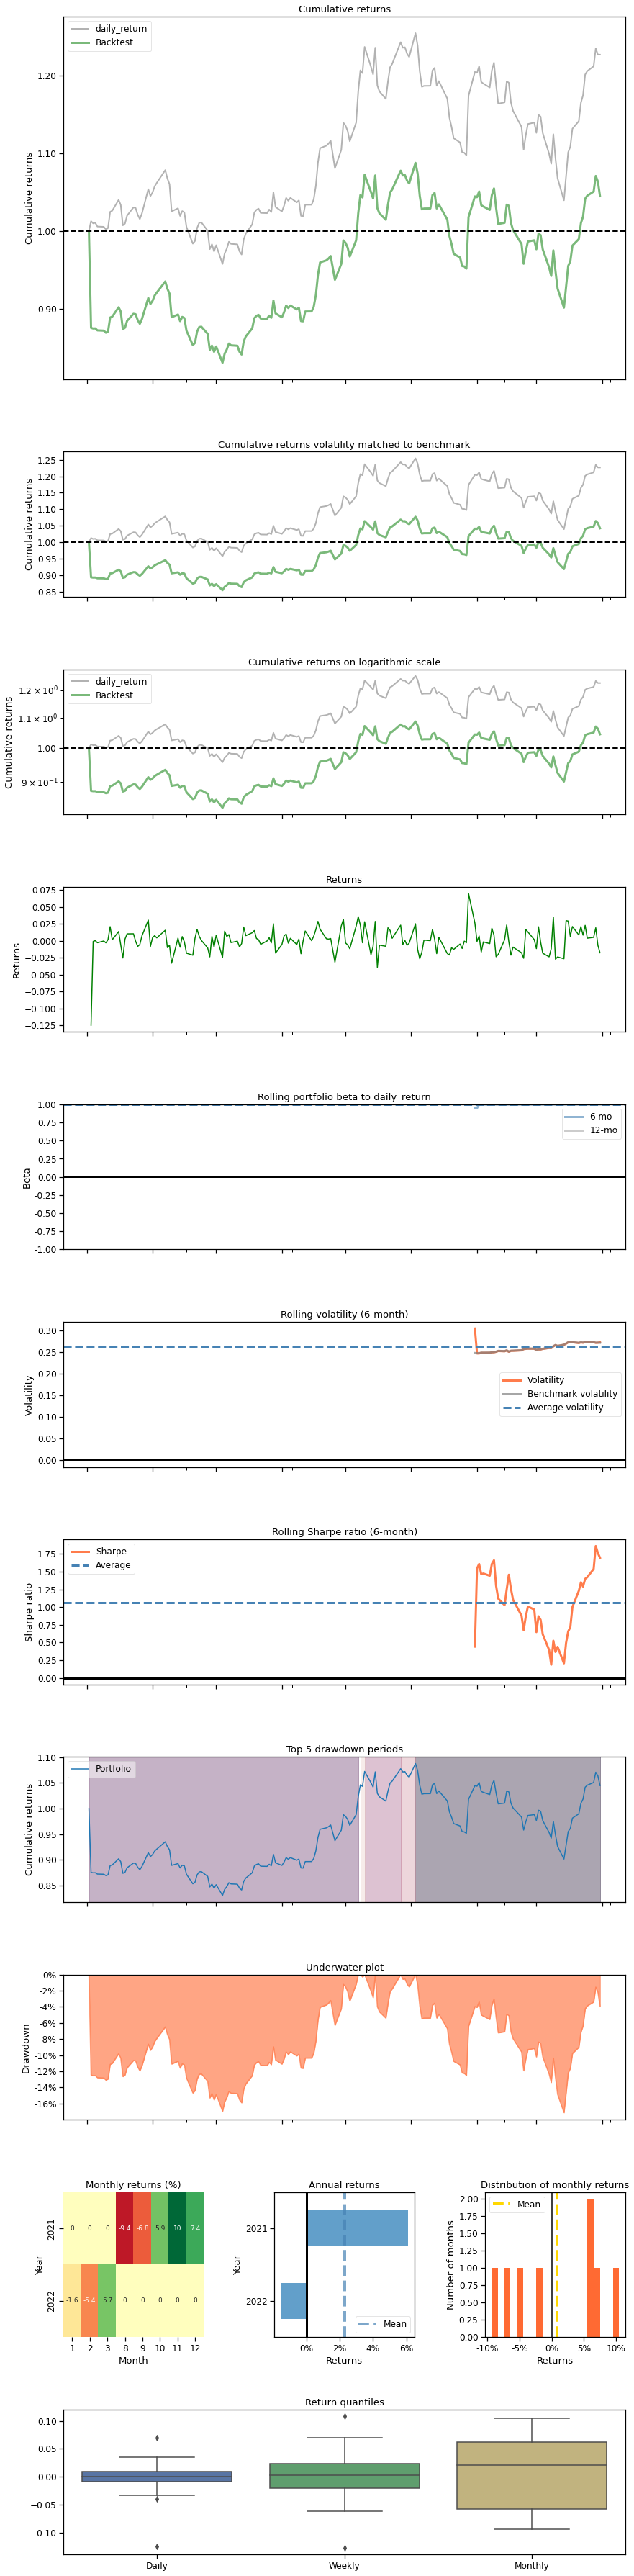

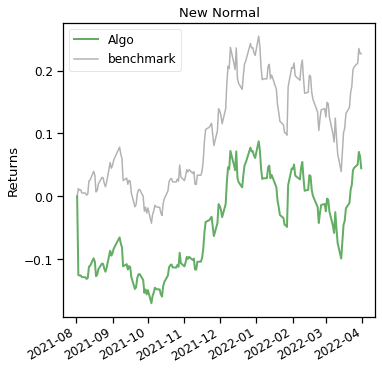

In [26]:
print("==============Compare to DJI===========")
%matplotlib inline

backtest_plot(
    account_value=df_account_value,
    baseline_ticker='AAPL',
    baseline_start=df_account_value.loc[0,'date'],
    baseline_end=df_account_value.loc[len(df_account_value)-1,'date']
)